# IMPORTS

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [2]:
data=pd.read_csv('wmap.csv')
data['x']

0        2
1        3
2        4
3        5
4        6
      ... 
894    896
895    897
896    898
897    899
898    900
Name: x, Length: 899, dtype: int64

In [85]:
data2=data[0:400]

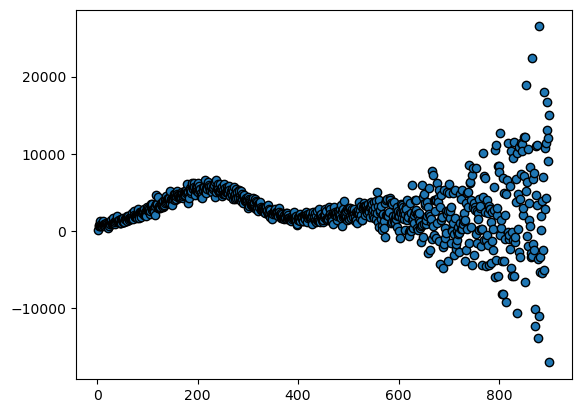

In [3]:
plt.figsize=(20,25)
plots=plt.scatter(data.x,data.y,edgecolors='black')
plt.show(plots)

# Functions

In [4]:
def power_func(x,d,q):
    G=[]
    x=np.array(x)
    j=1
    for i in range(0,(d+1+q)):
        if i<(d+1):
            G.append(x**i)
        else:
            sottr=x[-1]/(q+1)*j #modificato il doppio diviso per il punto 2
            G.append((np.maximum(0,x-sottr))**d)
            j+=1
            
    return G

In [5]:
G_prova=power_func(list(np.linspace(0,1,1000)),1,3)

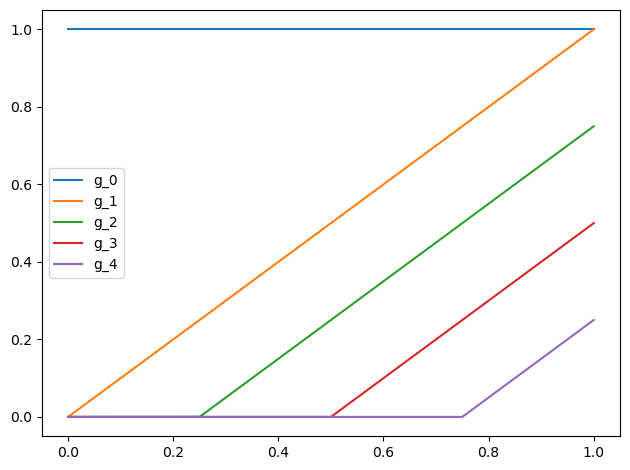

In [6]:
#Plot the loss function
fig=plt.plot(figsize=(25,20))

for i in range(0,5):
    plt.plot(list(np.linspace(0,1,1000)),G_prova[i],label =("g_{}").format(i))

plt.legend()
plt.tight_layout()
plt.show()



In [7]:
def pre_processing(x,d,q):
    mat=power_func(x,d,q)
    mat=np.array(mat)
    return np.transpose(mat)

In [55]:
def GCV_score (d,q,x=data.x,y=data.y):
    X = pre_processing(x,d,q)
    plm = LinearRegression(fit_intercept=False).fit(X,data.y)
    Y_hat = plm.predict(X)
    MSE_tr = mean_squared_error(y,Y_hat)
    GCV_score=MSE_tr/((1-((d+1)/len(x)))**2)
    return GCV_score

In [110]:
def main(d,q,type_,df):
    x=df.x
    y=df.y
    if type_=='GCV':
        scores=GCV_score(d,q,x,y)
    elif type_=='SCV':
        scores=SCV_score(d,q,10,df)
    return round(scores,2)

# GCV d=3

19 9107396.91


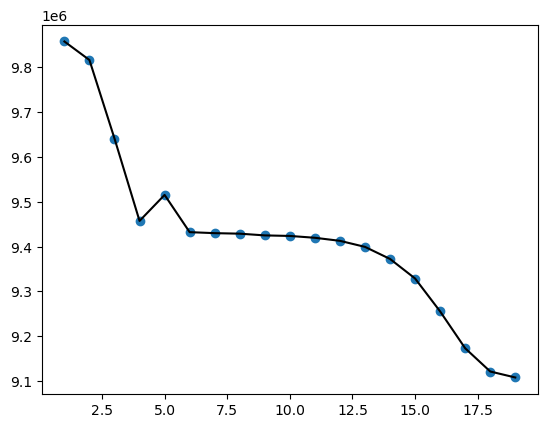

In [108]:
# for d=3 
knots=list(range(1,20))
# print(knots)
res=list(map(main,[3]*len(knots),knots,['GCV']*len(knots),[data]*len(knots)))
ind=np.argmin(res)
print(knots[ind],res[ind])
plt.scatter(knots,res)
plt.plot(knots,res,color='black')
plt.show()

# GCV d=1

9 9383559.66


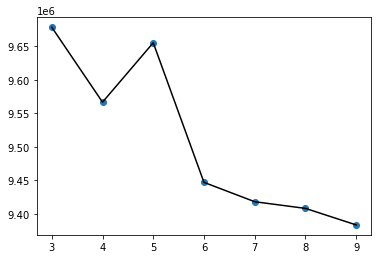

In [94]:
# for d=1 
knots=list(range(3,10))
# print(knots)
res=list(map(main,[1]*len(knots),knots,data.x,data.y))
ind=np.argmin(res)
print(knots[ind],res[ind])
plt.scatter(knots,res)
plt.plot(knots,res,color='black')
plt.show()

# Stratified CV

In [35]:
def assign_folds(k,d=data):
    if k<=1:
        raise TypeError("Only integers >1 are allowed") 
    #k=n_folds>1
    folds=[]
    
    #Assign classes
    d.loc[0:399,'class']=0
    d.loc[400:900,'class']=1
    d=d.astype({'class':int})
    
    #Assign a column to determine whether a row has already been used or not
    d.loc[0:900,'picked'] = 0

    #Create folds
    for i in range(k):
        sample=d[d['picked']==0].groupby('class', group_keys=False).apply(lambda x: x.sample(frac=1/(k-i))) 
        #set to 1 the picked rows
        d.loc[sample.index,'picked']=1
        #save the single fold
        folds.append(sample)   
        
    return (folds)

In [104]:
def SCV_score(d,q,k,df):
    folds=assign_folds(k,df)
    SCV=[]
    for i in range(len(folds)):
        val=folds[i]
        tr=p2.drop(val.index)
        x=tr.x
        y=tr.y
        x_out=val.x
        y_out=val.y
    
        X = pre_processing(x,d,q)
        X_out = pre_processing(x_out,d,q)
        plm = LinearRegression(fit_intercept=False).fit(X,y)

        Y_hat = plm.predict(X_out)
        MSE_cv = mean_squared_error(y_out,Y_hat)
        SCV.append(MSE_cv)
    return np.mean(SCV)
        
        
    

1 94670544.63


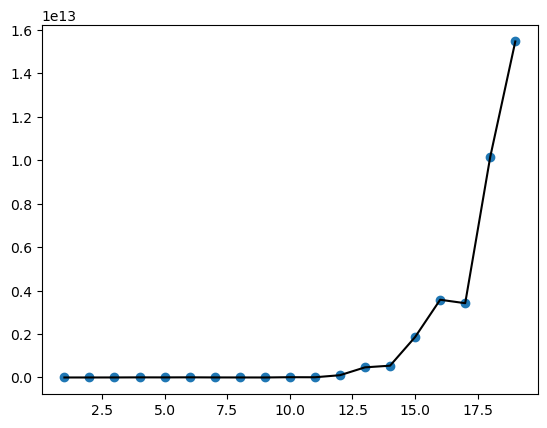

In [112]:
# for d=3 
knots=list(range(1,20))
# print(knots)
res=list(map(main,[3]*len(knots),knots,['SCV']*len(knots),[data]*len(knots)))
ind=np.argmin(res)
print(knots[ind],res[ind])
plt.scatter(knots,res)
plt.plot(knots,res,color='black')
plt.show()

# porcherie

In [ ]:
res

In [ ]:
data2=data[400:]

In [16]:
X=pre_processing(data.x,1,23)
print(X)


[[  1.    2.    0.  ...   0.    0.    0. ]
 [  1.    3.    0.  ...   0.    0.    0. ]
 [  1.    4.    0.  ...   0.    0.    0. ]
 ...
 [  1.  898.  860.5 ... 110.5  73.   35.5]
 [  1.  899.  861.5 ... 111.5  74.   36.5]
 [  1.  900.  862.5 ... 112.5  75.   37.5]]


In [17]:
plm=LinearRegression(fit_intercept=False).fit(X,data.y)
c=plm.coef_
c
score=plm.score(X,data.y)
score


0.15554534424977817

In [ ]:
plm = LinearRegression(fit_intercept=False).fit(X,data.y)
Y_hat_ = plm.predict(X)
MSE_tr_ = mean_squared_error(data.y,Y_hat_)
GCV_score_ = MSE_tr_/((1-((3+1)/len(data.x)))**2)
print(MSE_tr_)

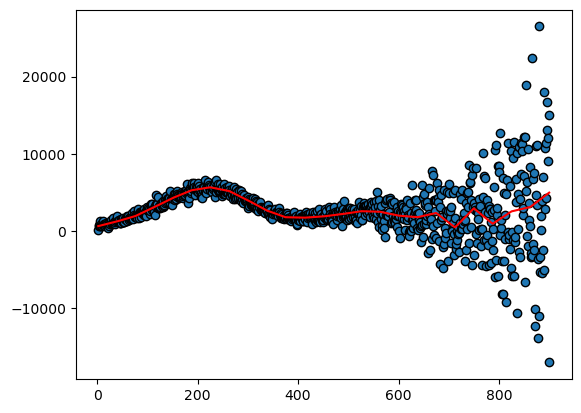

In [18]:
plt.scatter(data.x,data.y,edgecolors='black')
plt.plot(data.x,np.sum((X*c),axis=1),color='red')
plt.show()
# evidenzia i knots

In [102]:
p2=data
folds=assign_folds(5,p2)
SCV=[]
for i in range(len(folds)):
    val=folds[i]
    tr=p2.drop(val.index)
    x=tr.x
    y=tr.y
    x_out=val.x
    y_out=val.y
    #print(x_out)
    #print(tr.x)
    X = pre_processing(x,3,10)
    X_out = pre_processing(x_out,3,10)
    plm = LinearRegression(fit_intercept=False).fit(X,y)

    Y_hat = plm.predict(X_out)
    MSE_cv = mean_squared_error(y_out,Y_hat)
    SCV.append(MSE_cv)
np.mean(SCV)

3933324613.1997557

# polyfit

In [ ]:
# polynomial test
poly=np.polyfit(data.x,data.y,1)
y_hat=np.polyval(poly,data.x)
mse=mean_squared_error(data.y,y_hat)
mse/((1-4/len(data.x))**2)